In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import pandas as pd
from scipy.integrate import quad_vec
from scipy.special import spherical_jn
from collections.abc import Iterable
from aidm.const import *
from astropy.table import Table

## set fig params|
sns.set_context("paper")
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {
        'text.latex.preamble': [r'\usepackage{amsmath}', r'\boldmath'],
        'text.usetex':True,
        'axes.labelsize':20.,
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'figure.figsize':[10., 8.],
        'font.family':'DejaVu Sans',
        'legend.fontsize':18}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline


u.set_enabled_equivalencies(u.mass_energy())

/Users/kpardo/opt/miniconda3/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [18]:
RECALC_LIMITS = False

In [34]:
exps = ['GDM', 'MAQRO', 'Pino', None, 'BECCAL']

In [54]:
data_dir = '../data/'

## load 5th force constraints + define conversion to sigma_n
ffmphi, ffyn = np.loadtxt(data_dir+'Force5thynVSmPhiGeV.dat', unpack=True)
ffmphi = (ffmphi*u.GeV).to(u.MeV)


def yn_to_sigman(yn, mx, mphi, yx=1, mux=None, vdm=vdm):
    if mux == None:
        mux = mx
    massfac = mux**2/(mphi**2+vdm**2*mx**2)**2
    sig_in_invGeV = (yn**2 * yx**2 * massfac * 1. / (4 * np.pi)).to(1./u.GeV**2)
    return (sig_in_invGeV*1./lp**2).to(u.cm**(2))


## load other constraints
HeNRdat = pd.read_csv(data_dir+'NR.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')
Hephodat = pd.read_csv(data_dir+'phonon2.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')


## self-interaction constraints
def sigma_self(mx, mphi, gstar=10):
    return (1.55e-24*u.cm**2*(mphi/mx)**4*(gstar/10)**(0.5)*(u.GeV/mx)).to(u.cm**2)

In [36]:
def plot_exp(ax, exp, qmin=True, mphi_ratios=mpr, medtype='light'):
    if RECALC_LIMITS:
        get_lim(exp, qmin=qmin, mphi_ratios=mphi_ratios, medtype=medtype)
    ## load data
    try:
        fn = f'../results/limits/{exp}_{qmin}_{medtype[0]}.dat'
        dat = Table.read(fn, format='ascii.ecsv')
        dat[f'sigma_{int(-1.*np.log10(mphi_ratios))}']
    except KeyError:
        print("Can't find column. Looking for single mphi version.")
        fn = f'../results/limits/{exp}_{qmin}_{medtype[0]}_{int(-1.*np.log10(mphi_ratios))}.dat'
        dat = Table.read(fn, format='ascii.ecsv')
    except (IOSError, OSError):
        print("Can't find file. Re-running limits.")
        get_lim(exp, qmin=qmin, mphi_ratios=mphi_ratios, medtype=medtype)
        fn = f'../results/limits/{exp}_{qmin}_{medtype[0]}_{int(-1.*np.log10(mphi_ratios))}.dat'
        dat = Table.read(fn, format='ascii.ecsv')
    if qmin:
        ls = 'solid'
        label = f'$\\rm{{{exp}}}$'
    else:
        ls = 'dashed'
        label = None
    ax.loglog(dat['mx'], dat[f'sigma_{int(-1.*np.log10(mphi_ratios))}'], lw=2, c=cs[exps.index(exp)], ls=ls, label=label)

In [67]:
def plot_specific_mphi(mpr, plot_noqmin=True):
    f, ax = plt.subplots(1,1, figsize=(10,6))

    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex)
        if plot_noqmin:
            plot_exp(ax, ex, qmin=False)
    ## text indicating mediator mass
    plt.text(0.15, 0.05,f'$m_{{\phi}} = 10^{{{int(np.log10(mpr))}}}m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)

    ## plot other limits
    ## self-interaction
    plt.loglog(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), color='k')
    plt.fill_between(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), 1, color='k', alpha=0.3, hatch='X')
    ffsigma = yn_to_sigman(ffyn, ffmphi*1./mpr, ffmphi)
    plt.loglog(ffmphi*1./mpr, ffsigma, color='k')
    plt.fill_between(ffmphi*1./mpr, ffsigma, 1., color='k', alpha=0.3)

    plt.loglog(10**HeNRdat['mx'], 10**HeNRdat['sigma'], color='black', alpha=0.5)
    plt.text(3, 1.e-43, 'He NR', color='gray', rotation=-20)
    plt.loglog(10**Hephodat['mx'], 10**Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
    plt.text(1.e-1, 9.e-44, 'He 2-phonon', color='gray', rotation=-42)

    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    plt.ylabel(r'$\bar{\sigma}_n~[\rm{cm}^2]$');
    plt.xlim([1.e-9, 1.e3])
    plt.ylim([1.e-45, 1.e-20])

    plt.savefig(f'../results/reach_plot_{int(-1.*np.log10(mpr))}.pdf')

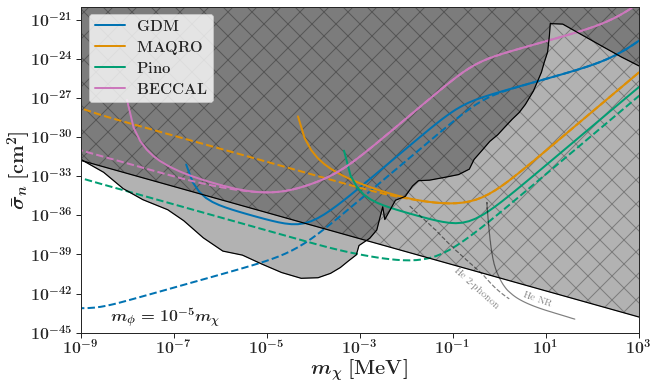

In [68]:
plot_specific_mphi(1.e-5)

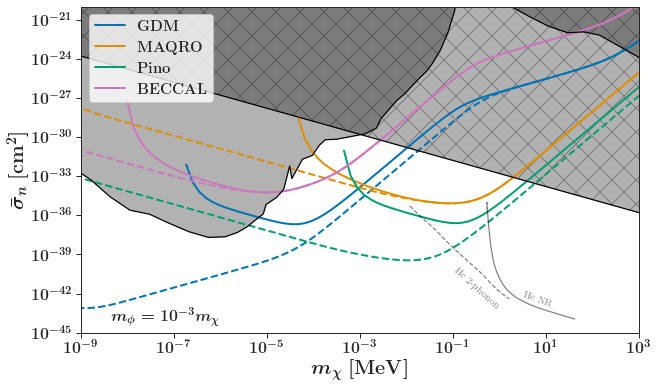

In [69]:
plot_specific_mphi(1.e-3)

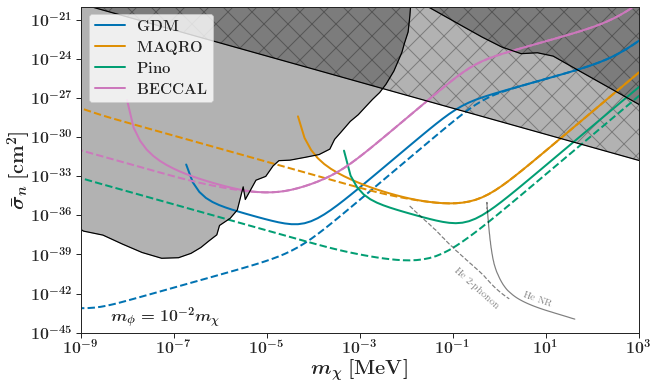

In [70]:
plot_specific_mphi(1.e-2)